<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Please take a look at the new comment below: as it turns out, the data is not actually lost after encoding. The other problem was fixed.
    
Thanks for taking the time to improve the project, it is accepted now, and you can move on to the next sprint. Good luck!

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Most of the problems were fixed, but could you please take another look at the OrdinalEncoder and outlier removal? It seems that we're corrupting some data in the process, which shouldn't happen if we want to trust our models. 
    
</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but there are a few problems that need to be fixed before the project is accepted. Let me know if you have any questions!

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [32]:
import numpy as np
import math
import pandas as pd
import timeit
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.metrics
import sklearn.preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import catboost as cb
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.utils import shuffle
from IPython.display import display
from collections import Counter

## Data preparation

In [115]:
df = pd.read_csv('/datasets/car_data.csv')
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


None

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

Renaming the columns for consistant style

In [116]:
df = df.rename(columns={'DateCrawled':'date_crawled', 'Price':'price', 'VehicleType':'vehicle_type', 
                        'RegistrationYear':'registration_year', 'Gearbox':'gearbox', 'Power':'power', 
                       'Model':'model', 'Mileage':'mileage', 'RegistrationMonth':'registration_month', 
                       'FuelType':'fuel_type', 'Brand':'brand', 'NotRepaired':'not_repaired', 'DateCreated':
                       'date_created', 'NumberOfPictures':'pictures', 'PostalCode':'postal_code', 'LastSeen':
                       'last_seen'})
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Since Rusty Bargain is only interested in accurate prediction of price, we can remove any features that don't really affect out target

<div class="alert alert-success">
<b>Reviewer's comment</b>

Makes sense!

</div>

In [117]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'pictures', 'last_seen'], axis=1)
df

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [118]:
#searching for duplicate rows
len(df) - len(df.drop_duplicates())

45040

In [119]:
df = df.drop_duplicates()
len(df) - len(df.drop_duplicates())

0

In [120]:
#Looking for 'none' str. values
df[df == 'None'].sum()

price                0.0
vehicle_type           0
registration_year    0.0
gearbox                0
power                0.0
model                  0
mileage              0.0
fuel_type              0
brand                  0
not_repaired           0
dtype: object

No 'none' values in the features

Next, checking percentage impact of null values on the data

In [121]:
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
not_repaired,64558,0.21
vehicle_type,34559,0.11
fuel_type,30764,0.10
model,18361,0.06
gearbox,17207,0.06
price,0,0.00
registration_year,0,0.00
power,0,0.00
mileage,0,0.00
brand,0,0.00


In [122]:
df.isna().sum()

price                    0
vehicle_type         34559
registration_year        0
gearbox              17207
power                    0
model                18361
mileage                  0
fuel_type            30764
brand                    0
not_repaired         64558
dtype: int64

There are missing values for vehicle type, gearbox, model, not_repaired and fuel_type (all are categorical). 

We can first handle 'gearbox' and 'not_repaired' easily

In [123]:
df['gearbox'].value_counts()

manual    232774
auto       59348
Name: gearbox, dtype: int64

In [124]:
#encoding gearbox
df["gearbox"] = (df['gearbox'] == 'auto').astype('int')
display(df['gearbox'].value_counts(), df.isna().sum())
#auto is now '1', manual '0'
#missing values became the majority class '0' or 'manual'

/tmp/ipykernel_53/606906564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gearbox"] = (df['gearbox'] == 'auto').astype('int')


0    249981
1     59348
Name: gearbox, dtype: int64

price                    0
vehicle_type         34559
registration_year        0
gearbox                  0
power                    0
model                18361
mileage                  0
fuel_type            30764
brand                    0
not_repaired         64558
dtype: int64

For 'not_repaired' if it is unknown whether the vehicle was repaired or not, intuitively, it is most likely safe to assume that it was not. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yeah, it seems plausible!

</div>

In [125]:
df['not_repaired'] = df['not_repaired'].fillna('yes')
df['not_repaired'] = (df['not_repaired'] == 'yes').astype('int')
df.isnull().sum()
#missing values & encoding has been handled

/tmp/ipykernel_53/2071015503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['not_repaired'] = df['not_repaired'].fillna('yes')
/tmp/ipykernel_53/2071015503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['not_repaired'] = (df['not_repaired'] == 'yes').astype('int')


price                    0
vehicle_type         34559
registration_year        0
gearbox                  0
power                    0
model                18361
mileage                  0
fuel_type            30764
brand                    0
not_repaired             0
dtype: int64

### Missing Values

There are missing values in vehicle_type, model, and fuel_type

In [126]:
#First, checking if there are any strange values

df['vehicle_type'].value_counts()
#nothing strange

sedan          78206
small          67548
wagon          56367
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: vehicle_type, dtype: int64

In [127]:
df['model'].value_counts()

golf                  23639
other                 22934
3er                   16700
polo                  10494
corsa                  9738
                      ...  
kalina                    7
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

In [128]:
df['fuel_type'].value_counts()

petrol      187848
gasoline     84794
lpg           4888
cng            524
hybrid         222
other          200
electric        89
Name: fuel_type, dtype: int64

**The features with missing values appear to be skewed based on the values counts, therefore the mode should be used to represent the missing data.**

In [129]:
#vehicle_type mode is 'sedan'

df['vehicle_type'] = df['vehicle_type'].fillna('sedan')
df['vehicle_type'].isnull().sum()

/tmp/ipykernel_53/1816488202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vehicle_type'] = df['vehicle_type'].fillna('sedan')


0

In [130]:
df['model'] = df['model'].fillna('golf')
df['model'].isnull().sum()

/tmp/ipykernel_53/1563800342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].fillna('golf')


0

In [131]:
df['fuel_type'] = df['fuel_type'].fillna('petrol')
df['fuel_type'].isnull().sum()

/tmp/ipykernel_53/1322158909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fuel_type'] = df['fuel_type'].fillna('petrol')


0

In [132]:
df.isnull().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
mileage              0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

In [133]:
#Encoding only the categorical features

#encoders = {}
#for column_name in ['vehicle_type', 'model', 'fuel_type', 'brand']:
    #encoders[column_name] = OrdinalEncoder()
    #df[column_name] = encoders[column_name].fit_transform((df[column_name].values.reshape(-1,1)))
#df

In [134]:
df

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,sedan,1993,0,0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,0,190,golf,125000,gasoline,audi,1
2,9800,suv,2004,1,163,grand,125000,gasoline,jeep,1
3,1500,small,2001,0,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,0,69,fabia,90000,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...,...
354364,0,sedan,2005,0,0,colt,150000,petrol,mitsubishi,1
354365,2200,sedan,2005,0,0,golf,20000,petrol,sonstige_autos,1
354366,1199,convertible,2000,1,101,fortwo,125000,petrol,smart,0
354367,9200,bus,1996,0,102,transporter,150000,gasoline,volkswagen,0


Try using .loc[row_indexer,col_indexer] = value instead

In [135]:
encoders = {}

for column_name in ['vehicle_type', 'model', 'fuel_type', 'brand']:
    encoders[column_name] = OrdinalEncoder()
    df.loc[:, [column_name]] = encoders[column_name].fit_transform(df[column_name].values.reshape(-1,1))
                                                               
df

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,4.0,1993,0,0,116.0,150000,6.0,38.0,1
1,18300,2.0,2011,0,190,116.0,125000,2.0,1.0,1
2,9800,6.0,2004,1,163,117.0,125000,2.0,14.0,1
3,1500,5.0,2001,0,75,116.0,150000,6.0,38.0,0
4,3600,5.0,2008,0,69,101.0,90000,2.0,31.0,0
...,...,...,...,...,...,...,...,...,...,...
354364,0,4.0,2005,0,0,78.0,150000,6.0,22.0,1
354365,2200,4.0,2005,0,0,116.0,20000,6.0,33.0,1
354366,1199,1.0,2000,1,101,106.0,125000,6.0,32.0,0
354367,9200,0.0,1996,0,102,224.0,150000,2.0,38.0,0


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

- Using label encoding is ok for tree-based models, but it is problematic for linear regression: there is no intrinsic order on fuel_type or brand for example. So you need to use different encoding for it.
- Also note that LabelEncoder is intended to be used for targets, a similar class to use with features is called OrdinalEncoder

</div>

<div class="alert alert-info">
  I used the Ordinal Encoder but for some reason, it has removed almost 50,000 rows from the df and I haven't been able to find any solutions for this.
</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Hmm, maybe it's connected to the warning that's printed above. Try using `.loc` as it suggests (also OrdinalEncoder can fit/transform multiple categorical columns, and then you wouldn't need reshaping):
    
```python 
df.loc[:, ['vehicle_type', 'model', 'fuel_type', 'brand']] = ...
```

</div>

<div class="alert alert-info">
<b>Student's comment V2</b>

So I tried to use ``` df.loc[:, [column_name]]``` in a variety of ways, but it still removes the rows. Also, I can't seem to get the code to work without the '''values.reshape(-1,1)''', it will produce an error no matter what I do.
    
Sorry this isn't fixed yet, I posted for help in Slack but I haven't gotten any feedback yet.
    
Is there something else that I needed to differently as well to make it all work? Thanks!
</div>

<div class="alert alert-warning">
<b>Reviewer's comment V3</b>

Ok, I just realized that after encoding the categorical columns the dataframe has exactly the same number of rows as before the encoding and 45040 rows were removed earlier when you dropped duplicates! So, I guess we both got confused here!

In any case, while your way works fine, you can still do it more efficiently as follows:
    
```python
categorical_features = ['vehicle_type', 'model', 'fuel_type', 'brand']
encoder = OrdinalEncoder()
df.loc[:, categorical_features] = encoder.fit_transform(df[categorical_features])
```

About the `SettingWithCopyWarning` warning you get, I found out that it is because after executing 
    
```python
df = df.drop_duplicates()
```
    
we end up working with a copy of a slice of the original dataframe.
    
To fix this, we can create a new dataframe like this:
    
```
df = df.drop_duplicates().copy()
```
    
and then the warnings go away :)
    
    
</div>

## Exploratory Data Analysis

**The main purpose for this step is to:** 

1) explore feature distributions 

2) remove any outliers in the data.

### Initial Feature Boxplots

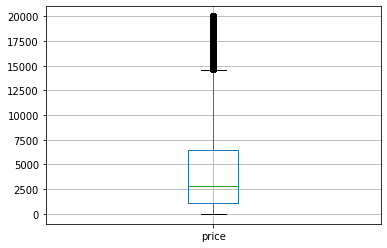

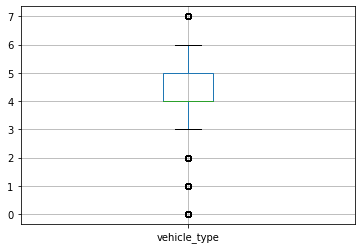

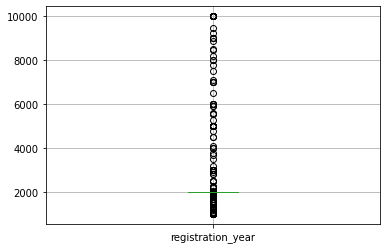

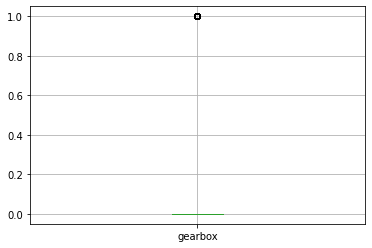

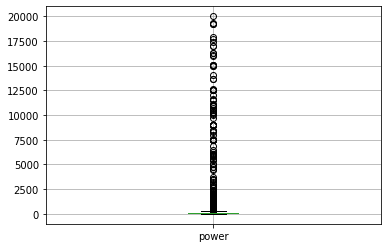

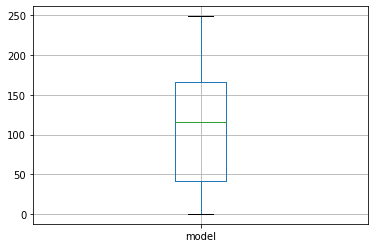

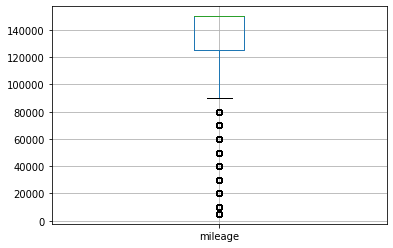

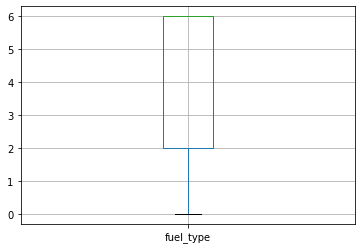

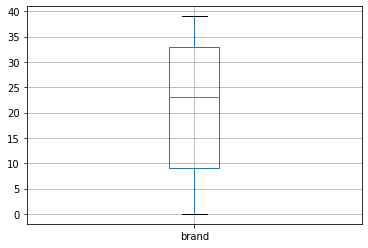

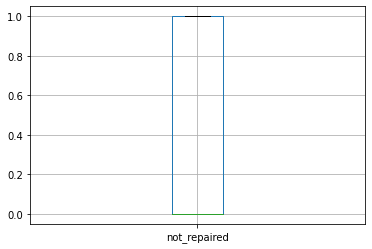

In [22]:
#Next, exploring the features for outliers 

for column in df:
    plt.figure()
    df.boxplot([column])

#### Initial Feature Boxplots: Conclusion

1)  The boxplots for registration_year and power are suspicious because the IQR box is hidden from all the extreme values. This needs to be further explored and fixed before outliers are removed amongst the entire dataset

### Handling Strange Boxplot Distributions

The strange values corrupting the distributions of power and registration_year are mostly likely errors in data input that represent themselves as outliers in the boxplots. To fix this, we will remove them.

In [23]:
#using IterativeImputer to predict the new missing values
#imp = IterativeImputer(random_state=0)
#imp.fit(df)

### Removing Outliers

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              309329 non-null  int64  
 1   vehicle_type       309329 non-null  float64
 2   registration_year  309329 non-null  int64  
 3   gearbox            309329 non-null  int64  
 4   power              309329 non-null  int64  
 5   model              309329 non-null  float64
 6   mileage            309329 non-null  int64  
 7   fuel_type          309329 non-null  float64
 8   brand              309329 non-null  float64
 9   not_repaired       309329 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 26.0 MB


In [25]:
#new df for features that make sense to eliminate outliers for 
df_parameters = df[['price', 'mileage', 'power', 'registration_year']].copy() #new df for parameters
df_parameters.head(10)

,price,mileage,power,registration_year
0,480,150000,0,1993
1,18300,125000,190,2011
2,9800,125000,163,2004
3,1500,150000,75,2001
4,3600,90000,69,2008
5,650,150000,102,1995
6,2200,150000,109,2004
7,0,40000,50,1980
8,14500,30000,125,2014
9,999,150000,101,1998


In [26]:
Q1 = df_parameters.quantile(0.25)
Q3 = df_parameters.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

price                 5400.0
mileage              25000.0
power                   74.0
registration_year        9.0
dtype: float64


In [27]:
df_outliers = df_parameters[((df_parameters < (Q1 - 1.5 * IQR)) |(df_parameters > (Q3 + 1.5 * IQR))).any(axis=1)]
df_parameters = df_parameters[~((df_parameters < (Q1 - 1.5 * IQR)) |(df_parameters > (Q3 + 1.5 * IQR))).any(axis=1)] #excluding the outliers
df_outliers.info() #there were 64,881 outliers
df_parameters.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64881 entries, 1 to 354365
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   price              64881 non-null  int64
 1   mileage            64881 non-null  int64
 2   power              64881 non-null  int64
 3   registration_year  64881 non-null  int64
dtypes: int64(4)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 244448 entries, 0 to 354368
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   price              244448 non-null  int64
 1   mileage            244448 non-null  int64
 2   power              244448 non-null  int64
 3   registration_year  244448 non-null  int64
dtypes: int64(4)
memory usage: 9.3 MB


Re-examining the previous boxplots

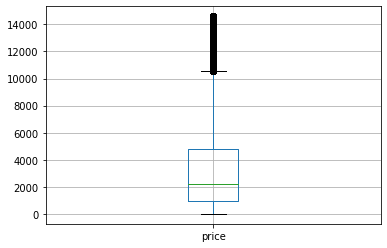

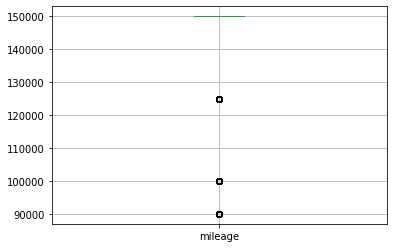

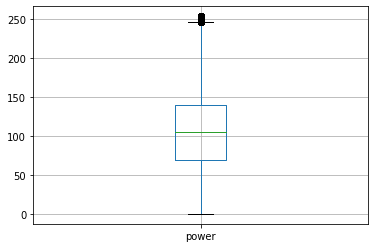

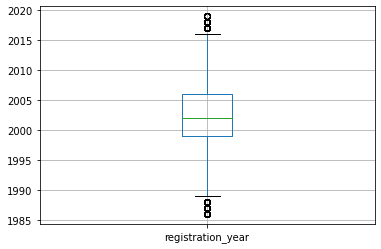

In [28]:
for column in df_parameters:
    plt.figure()
    df_parameters.boxplot([column])

The boxplots look better than before

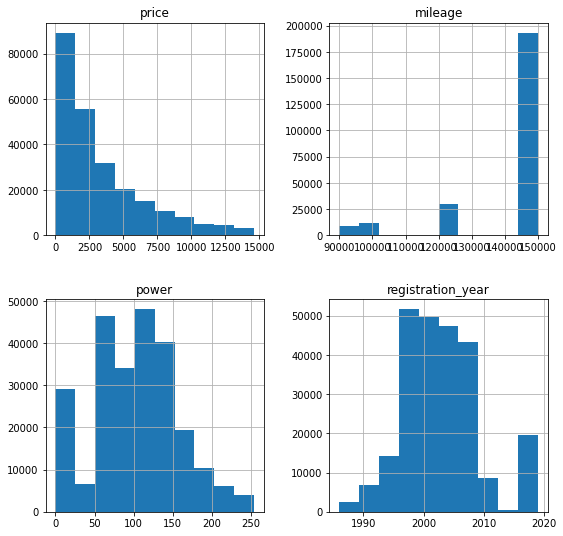

In [29]:
#viewing the histograms
df_parameters.hist(figsize=(9,9))
plt.show()

In [30]:
df_parameters.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244448 entries, 0 to 354368
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   price              244448 non-null  int64
 1   mileage            244448 non-null  int64
 2   power              244448 non-null  int64
 3   registration_year  244448 non-null  int64
dtypes: int64(4)
memory usage: 9.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              309329 non-null  int64  
 1   vehicle_type       309329 non-null  float64
 2   registration_year  309329 non-null  int64  
 3   gearbox            309329 non-null  int64  
 4   power              309329 non-null  int64  
 5   model              309329 non-null  float64
 6   mileage            309329 non-null  int64  
 7   fuel_type    

In [31]:
#df = pd.merge(df, df_parameters,  how='right', on=['price', 'mileage', 'power', 'registration_year'])

#df.hist(column=['price', 'mileage', 'power', 'registration_year'], figsize=(9,9))
#plt.show()

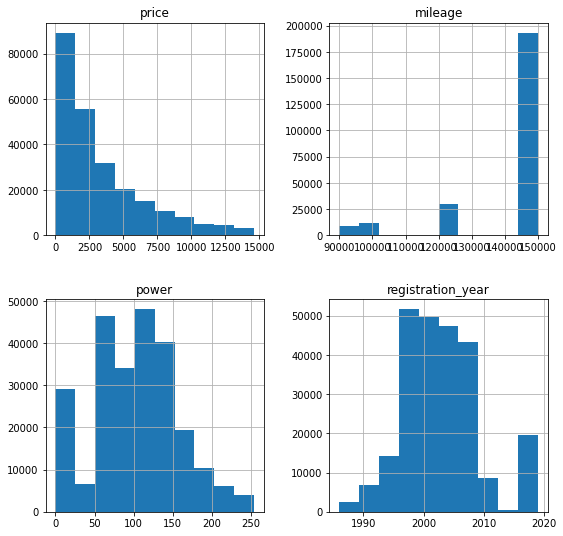

In [32]:
df = df.drop(df_outliers.index) #dropping the outliers from original df
df 

df.hist(column=['price', 'mileage', 'power', 'registration_year'], figsize=(9,9))
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244448 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              244448 non-null  int64  
 1   vehicle_type       244448 non-null  float64
 2   registration_year  244448 non-null  int64  
 3   gearbox            244448 non-null  int64  
 4   power              244448 non-null  int64  
 5   model              244448 non-null  float64
 6   mileage            244448 non-null  int64  
 7   fuel_type          244448 non-null  float64
 8   brand              244448 non-null  float64
 9   not_repaired       244448 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 20.5 MB


<div class="alert alert-info">
  The histograms are slightly different after the merge (it is apparent especially in the registration_year feature)
</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Great analysis of outliers, but it seems that merging `df` and `df_parameter` produced an incorrect result. I suggest doing one of the following:
    
1. Filtering `df` directly
2. Or finding the indices to be removed using the copy dataframe, and then dropping them from the original dataframe using `drop` method

</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Ok, that works!

</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice work on missing values!

</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

I would suggest digging a bit deeper in the data, as there are some other problems apart from missing values. Checking feature distributions and making sure that they are reasonable would be a good first step

</div>

## Model training

- Train different models with various hyperparameters (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.

1) Create a Linear Regression model as a sanity check for future methods

2) Create a Random Forest model with hyperparameter tuning

3) Create a LightGBM model with hyperparameter tuning 

4) Create a CatBoost model 

5) Create a XGBoost model 

**Since the training of a gradient boosting model can take a long time, change only a few model parameters.**

### Linear Regression Sanity Check

In [34]:
features = df.drop(['price'], axis=1)
target = df['price']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.70, 
                                                    random_state=12345)


model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse**0.5
print('RMSE:', rmse)

RMSE: 2318.432011093467


<div class="alert alert-warning">
<b>Reviewer's comment</b>

I don't quite see the point of dividing the target by 10000 to 'avoid large numbers': as you're printing quite a few numbers after the decimal point this just amounts to moving the decimal point. And it seems more useful to see the original RMSE measured in dollars.

</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test reasonably

</div>

### Random Forest Model

Splitting the data for validation and test sets

In [35]:
#train: 0.8
#valid: 0.1
#test: 0.1

X_train, X_rem, y_train, y_rem = train_test_split(features, target, train_size=0.80, 
                                                    random_state=12345)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size=0.5, 
                                                    random_state=12345)

In [36]:
results_rf = []

for estimator in range(1, 6):
    model = RandomForestRegressor(random_state=12345, n_estimators=estimator)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    results_rf.append({
                'RMSE': mean_squared_error(y_valid, preds)**0.5,
                'n_estimator': estimator})
    
results_rf = pd.DataFrame(results_rf)
results_rf = results_rf.sort_values(by='RMSE', ascending=False)
results_rf

,RMSE,n_estimator
0,1774.831369,1
1,1617.685857,2
2,1557.199221,3
3,1527.859985,4
4,1503.780746,5


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Using the test set for hyperparameter tuning leads to a biased test set score. You need to either use a separate validation set or cross-validation on the train set to tune hyperparameters, and then evaluate the final model on the test set.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great, validation set works!

</div>

**n_estimator 5 had the best RMSE  score**

In [37]:
%%time

#final model eval
model = RandomForestRegressor(random_state=12345, n_estimators=5)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds)**0.5
print('RMSE:', rmse)
#print('time:', timeit.timeit(preds))

RMSE: 1530.9715127261368
CPU times: user 1.82 s, sys: 6.65 ms, total: 1.82 s
Wall time: 1.83 s


### CatBoost Model

In [38]:
df = df.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244448 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   price              244448 non-null  int64
 1   vehicle_type       244448 non-null  int64
 2   registration_year  244448 non-null  int64
 3   gearbox            244448 non-null  int64
 4   power              244448 non-null  int64
 5   model              244448 non-null  int64
 6   mileage            244448 non-null  int64
 7   fuel_type          244448 non-null  int64
 8   brand              244448 non-null  int64
 9   not_repaired       244448 non-null  int64
dtypes: int64(10)
memory usage: 20.5 MB


In [39]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,4,1993,0,0,116,150000,6,38,1
2,9800,6,2004,1,163,117,125000,2,14,1
3,1500,5,2001,0,75,116,150000,6,38,0
4,3600,5,2008,0,69,101,90000,2,31,0
5,650,4,1995,0,102,11,150000,6,2,1


In [40]:
#redefining features & target for required int dtype in cat_features

features = df.drop(['price'], axis=1)
target = df['price']

In [41]:
#No need for validation set for now since we are limiting hyperparameter tuning

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.80, 
                                                    random_state=12345)

#Pool is required to pinpoint the target variables & predictors to be fitted to the model

pool_train = Pool(X_train, y_train,
                  cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                                         'brand', 'not_repaired'])

pool_test = Pool(X_test, cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                                         'brand', 'not_repaired'])

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Yeah, that's one way! Another would be to just specify the `cat_features` when initializing `CatBoostRegressor`

</div>

In [42]:
%%time

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')

#model.fit(X_train, y_train, eval_set=(X_valid, y_valid),plot=True)

model.fit(pool_train)
pred = model.predict(pool_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
print('Testing performance')
print('RMSE:', rmse)

0:	learn: 3065.3598301	total: 101ms	remaining: 4.96s
1:	learn: 2928.1849326	total: 149ms	remaining: 3.57s
2:	learn: 2808.7434551	total: 187ms	remaining: 2.92s
3:	learn: 2707.3794065	total: 221ms	remaining: 2.54s
4:	learn: 2608.5229008	total: 255ms	remaining: 2.29s
5:	learn: 2530.3965684	total: 299ms	remaining: 2.19s
6:	learn: 2454.4913322	total: 339ms	remaining: 2.08s
7:	learn: 2393.9387375	total: 372ms	remaining: 1.96s
8:	learn: 2337.5377026	total: 406ms	remaining: 1.85s
9:	learn: 2284.0504601	total: 441ms	remaining: 1.76s
10:	learn: 2231.5217908	total: 478ms	remaining: 1.7s
11:	learn: 2179.6545630	total: 512ms	remaining: 1.62s
12:	learn: 2137.6948404	total: 548ms	remaining: 1.56s
13:	learn: 2099.4171036	total: 581ms	remaining: 1.49s
14:	learn: 2064.0756262	total: 615ms	remaining: 1.44s
15:	learn: 2033.9096865	total: 648ms	remaining: 1.38s
16:	learn: 1999.1003922	total: 682ms	remaining: 1.32s
17:	learn: 1973.0236496	total: 722ms	remaining: 1.28s
18:	learn: 1949.7611928	total: 754ms	re

### LightGBM Model

In [43]:
%%time

model = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=50, random_state=42)
model.fit(X_train, y_train, categorical_feature=['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                                         'brand', 'not_repaired'])
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))

print('Testing performance')
print('RMSE:', rmse)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Testing performance
RMSE: 1416.098941858433
CPU times: user 2.78 s, sys: 17.2 ms, total: 2.79 s
Wall time: 2.77 s


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Lightgbm and catboost need you to specify which features are to be treated as categorical: you can pass a list of categorical feature names in `categorical_feature` and `cat_features` respectively when initializing the models

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great!

</div>

### XGBoost Model

In [44]:
%%time

model = xgb.XGBRegressor(n_estimators=100, max_depth=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))

print('Testing performance')
print('RMSE:', rmse)

Testing performance
RMSE: 1487.5134594771823
CPU times: user 15.7 s, sys: 37.5 ms, total: 15.8 s
Wall time: 15.9 s


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

While you tried a couple of different models and did some hyperparameter tuning, the time it takes to train or make predictions was never measured: `timeit.timeit()` measure the time it takes to run the function it is given as an argument. As you're giving it nothing, it doesn't measure anything useful. 

</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Excellent, now the time is measured correctly! One way to improve our analysis would be to separately measure the time it takes to fit each model and the time it takes to make predictions on the test set.

</div>

## Model analysis

**Linear model**:

RMSE: 2318

**Random Forest model**:

RMSE: 1530
time: 1.84s

**Catboost model**: 

RMSE: 1644
time 2.82s

**LightGBM model**:

RMSE: 1416
time 2.65s

**XGBoost model**:

RMSE: 1487
time 24.4s

#### Conclusion:

1) All models exceeded the linear model sanity check.

2) Of the gradient boosting models, LightGBM had the least amount of error with 1415 RMSE while Catboost had the most error with 1644 RMSE.

3) Of the gradient boosting models, LightGBM was the fastest at 2.65s while XGBoost was the slowest at 24.4s.

4) Of all the methods used, the LightGBM model was both fast and more accurate than the GB methods. This is the model I recommend Rusty Bargain uses.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Please review the conclusions after fixing the problems above

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Alright!

</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed